[Getting Started with Gaming on Cloud Spanner](https://www.cloudskillsboost.google/focuses/49544?catalog_rank=%7B%22rank%22%3A4%2C%22num_filters%22%3A0%2C%22has_search%22%3Atrue%7D&parent=catalog&search_id=23642501)

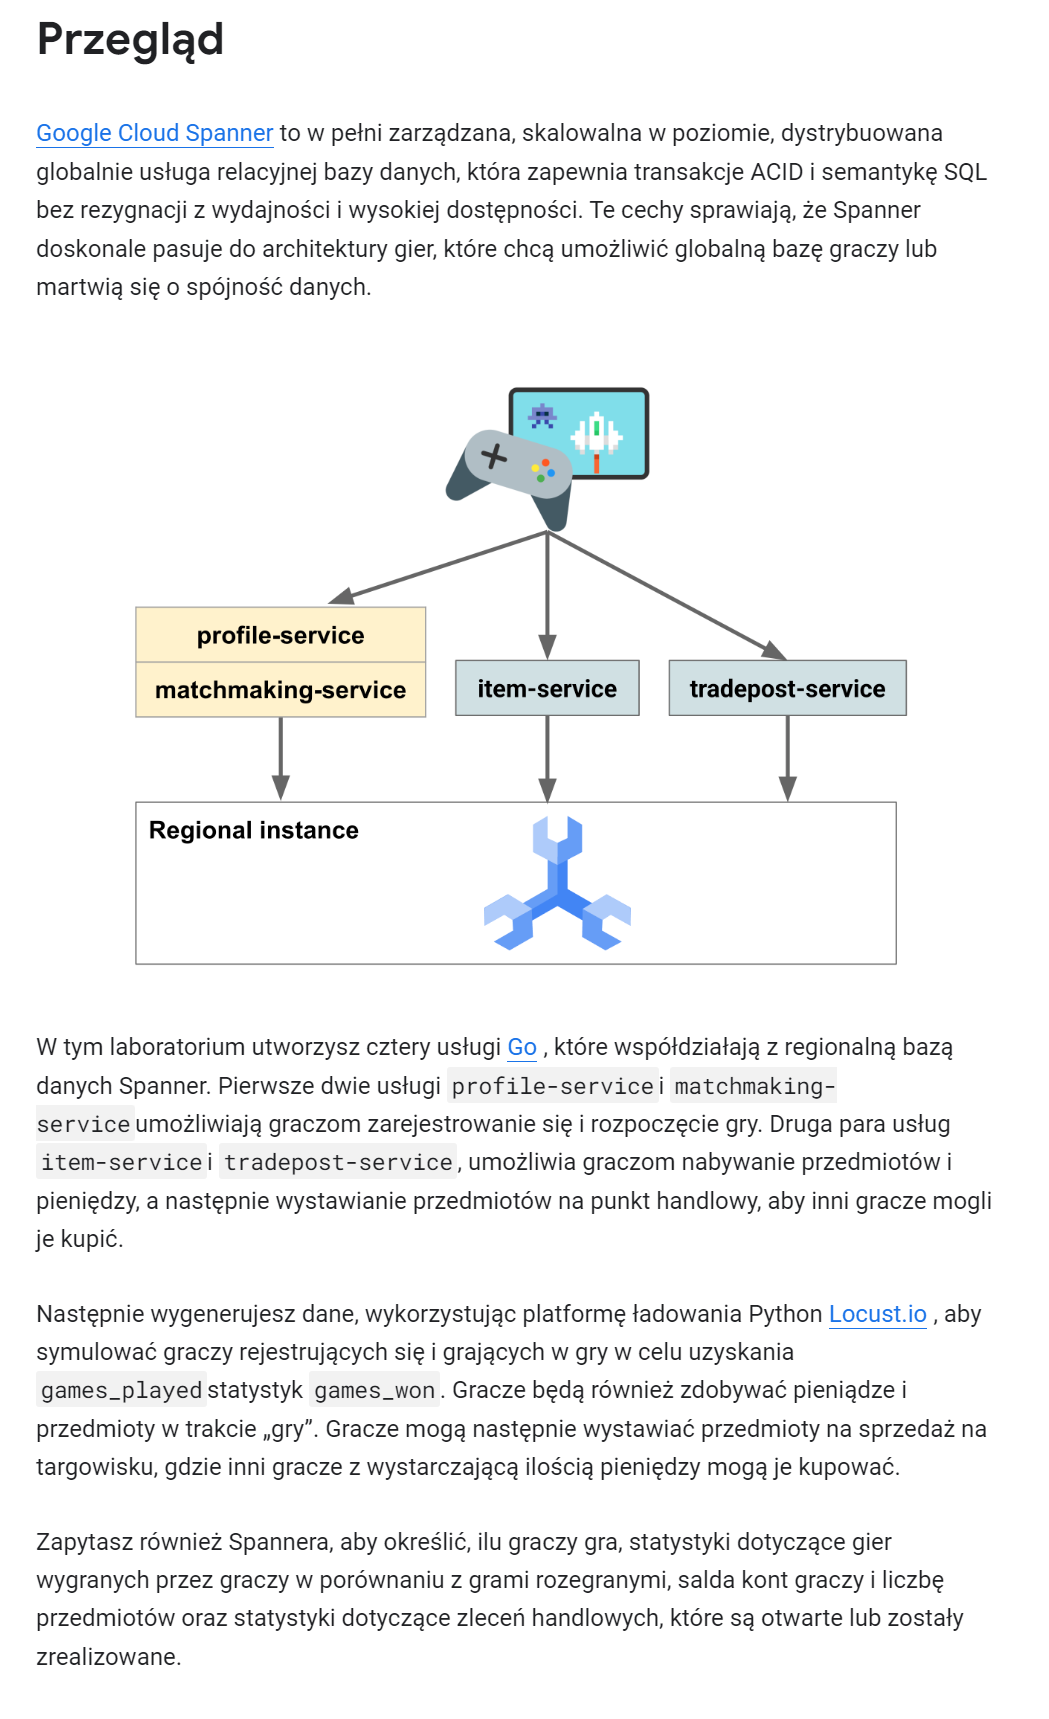

In [ ]:
# https://go.dev/

# https://locust.io/

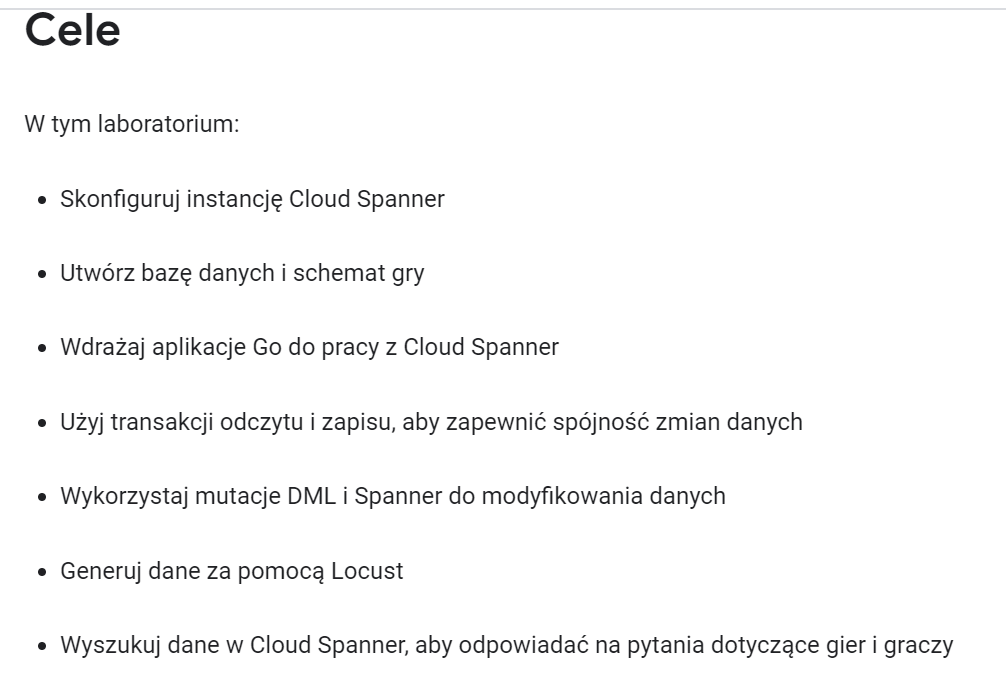

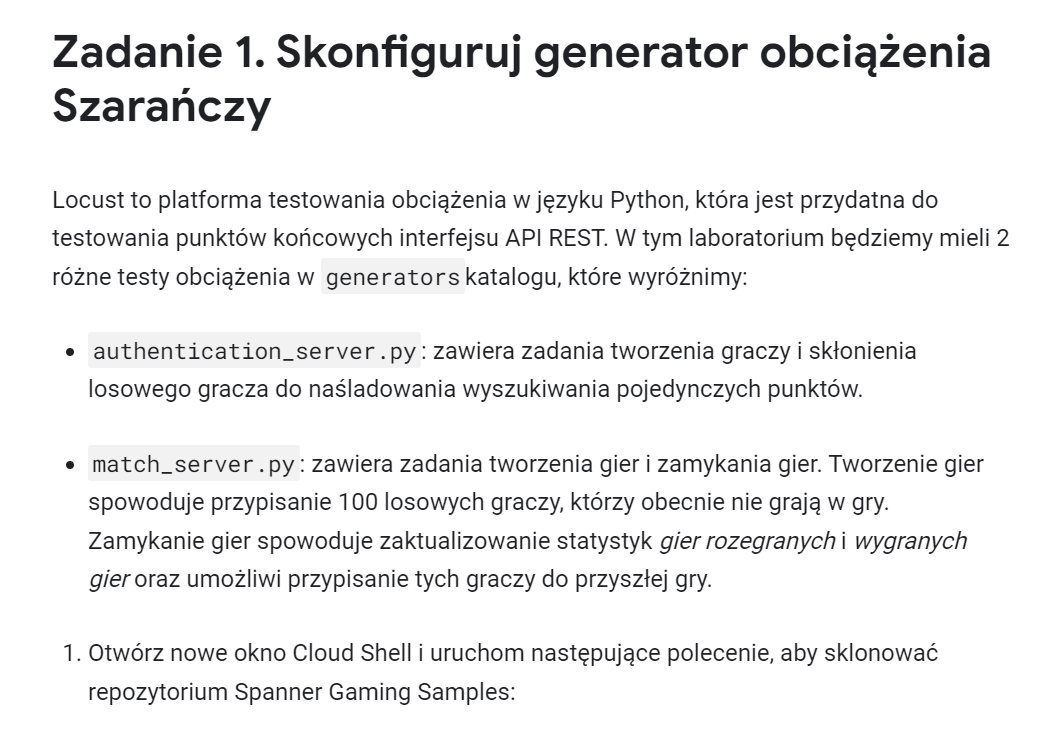

In [ ]:
git clone https://github.com/cloudspannerecosystem/spanner-gaming-sample.git
cd spanner-gaming-sample/

`./generators/authentication_server.py`

In [ ]:
from locust import HttpUser, task, events
from locust.exception import RescheduleTask
import string
import json
import random
import requests
class PlayerLoad(HttpUser):
   def on_start(self):
       global pUUIDs
       pUUIDs = []
   def generatePlayerName(self):
       return ''.join(random.choices(string.ascii_lowercase + string.digits, k=32))
   def generatePassword(self):
       return ''.join(random.choices(string.ascii_lowercase + string.digits, k=32))
   def generateEmail(self):
       return ''.join(random.choices(string.ascii_lowercase + string.digits, k=32) + ['@'] +
           random.choices(['gmail', 'yahoo', 'microsoft']) + ['.com'])
    @task
    def createPlayer(self):
        headers = {"Content-Type": "application/json"}
        data = {"player_name": self.generatePlayerName(), "email": self.generateEmail(), "password": self.generatePassword()}
        with self.client.post("/players", data=json.dumps(data), headers=headers, catch_response=True) as response:
            try:
                pUUIDs.append(response.json())
            except json.JSONDecodeError:
                response.failure("Response could not be decoded as JSON")
            except KeyError:
                response.failure("Response did not contain expected key 'gameUUID'")

`./generators/match_server.py`

In [ ]:
from locust import HttpUser, task
from locust.exception import RescheduleTask
import json
class GameMatch(HttpUser):
   def on_start(self):
       global openGames
       openGames = []
   @task
   def createGame(self):
       headers = {"Content-Type": "application/json"}
       # Create the game, then store the response in memory of list of open games.
       with self.client.post("/games/create", headers=headers, catch_response=True) as response:
           try:
               openGames.append({"gameUUID": response.json()})
           except json.JSONDecodeError:
               response.failure("Response could not be decoded as JSON")
           except KeyError:
               response.failure("Response did not contain expected key 'gameUUID'")
   @task
   def closeGame(self):
       # No open games are in memory, reschedule task to run again later.
       if len(openGames) == 0:
           raise RescheduleTask()
       headers = {"Content-Type": "application/json"}
       # Close the first open game in our list, removing it to avoid
       # contention from concurrent requests
       game = openGames[0]
       del openGames[0]
       data = {"gameUUID": game["gameUUID"]}
       self.client.put("/games/close", data=json.dumps(data), headers=headers)

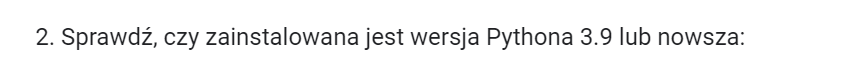

In [ ]:
python -V

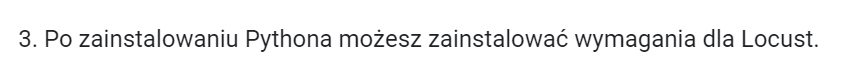

In [ ]:
pip3 install -r requirements.txt

`requirements.txt`

In [ ]:
locust==2.11.1

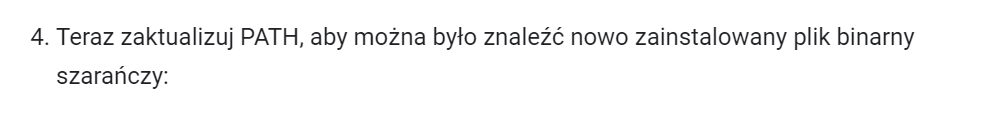

In [ ]:
PATH="~/.local/bin:$PATH"
which locust

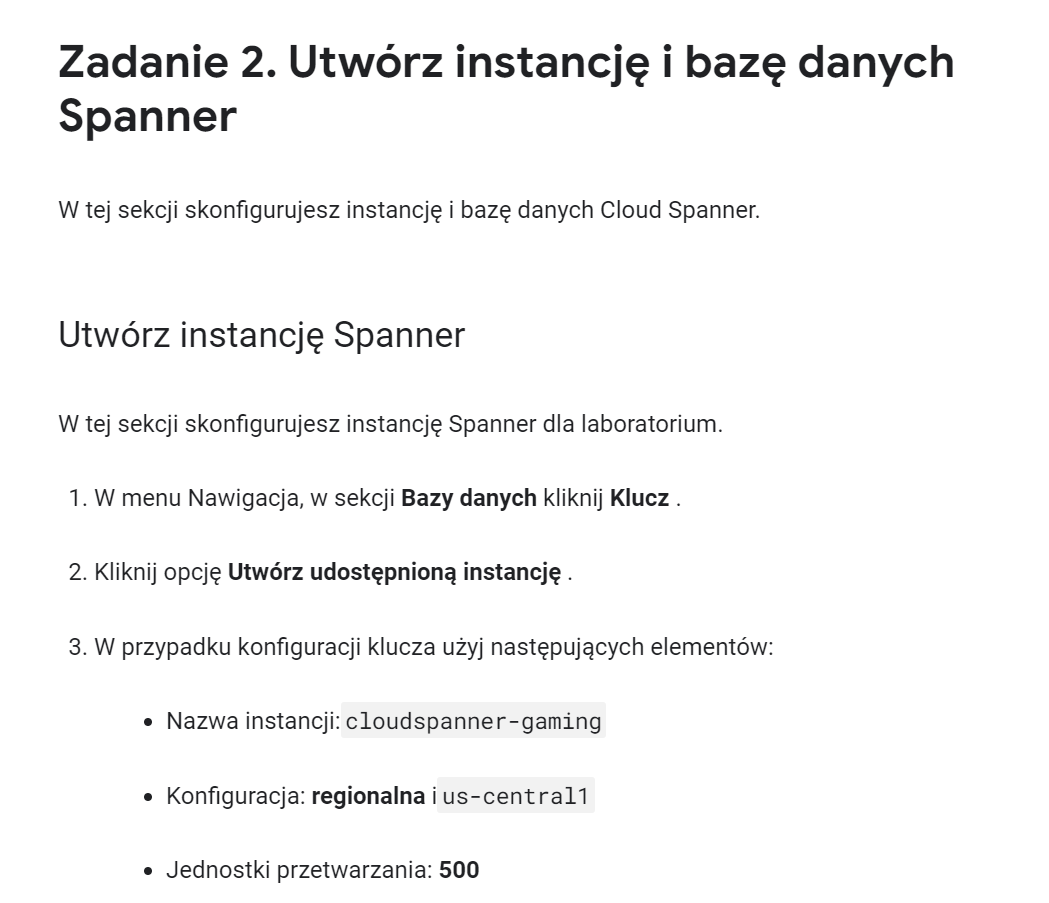

In [ ]:
# cloudspanner-gaming

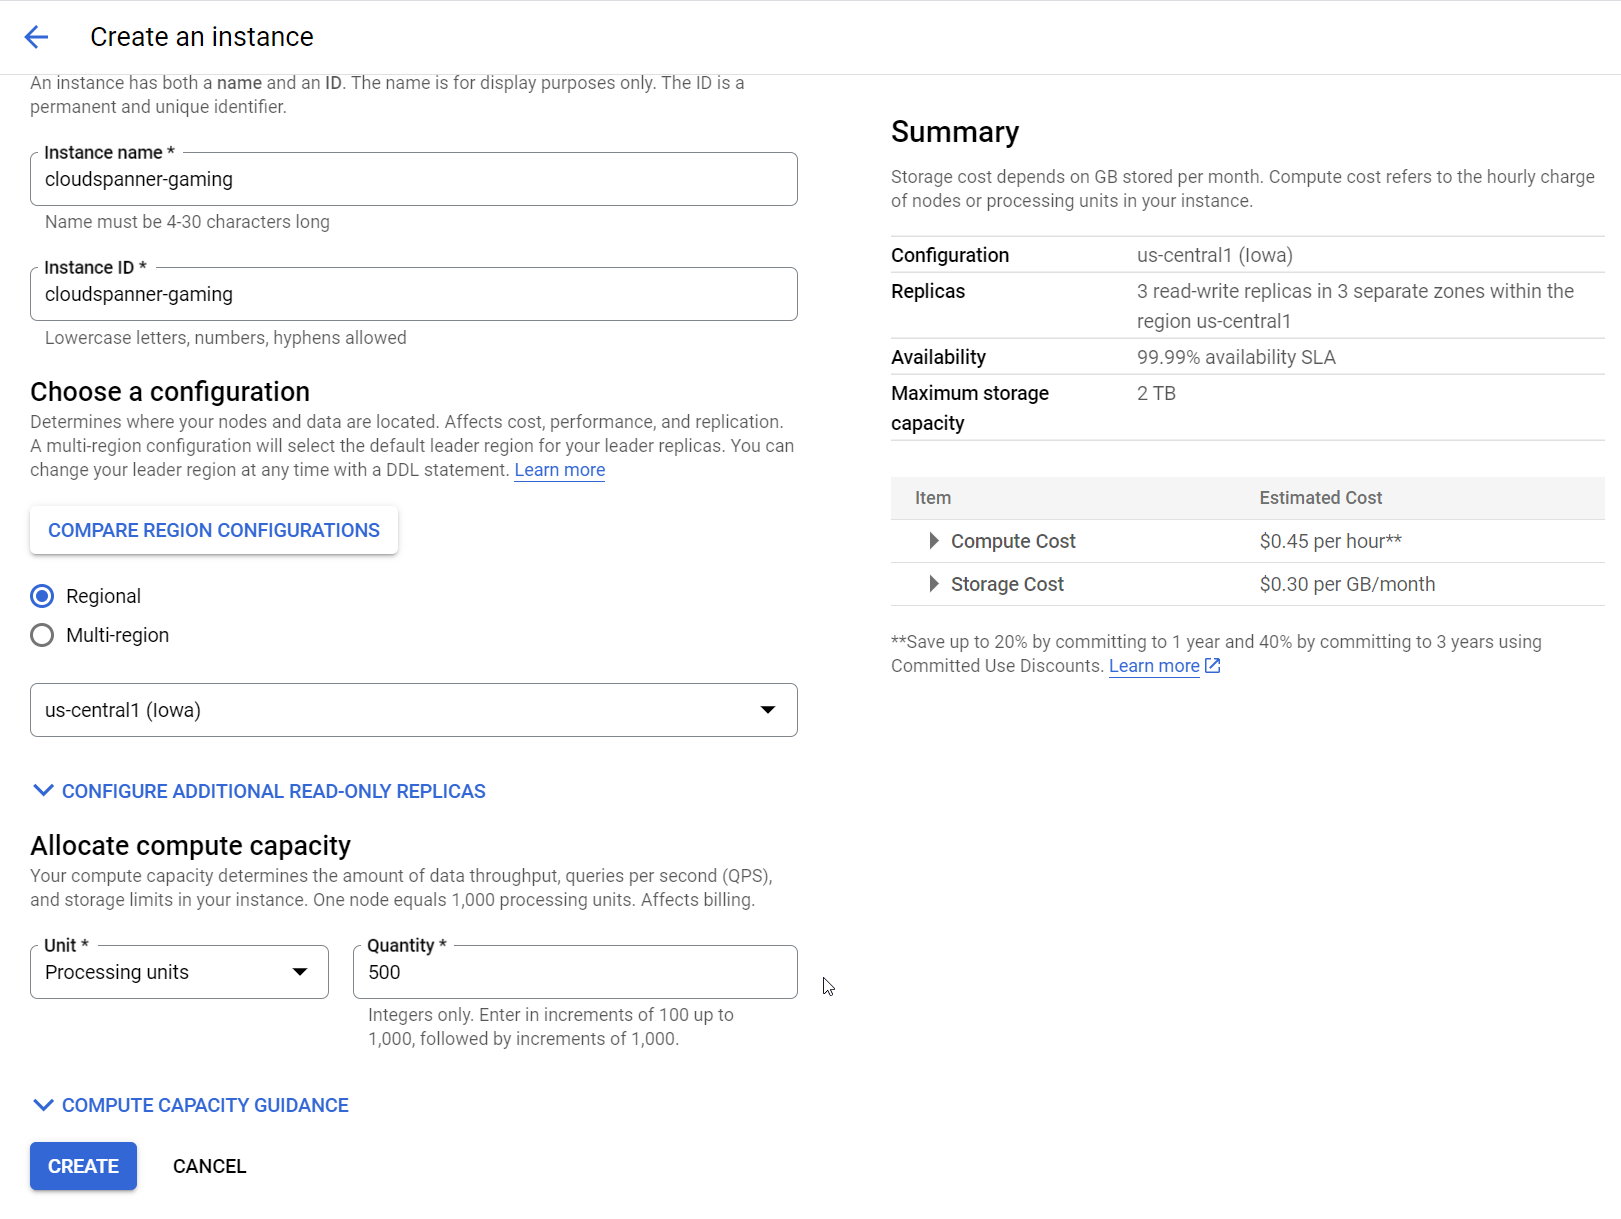

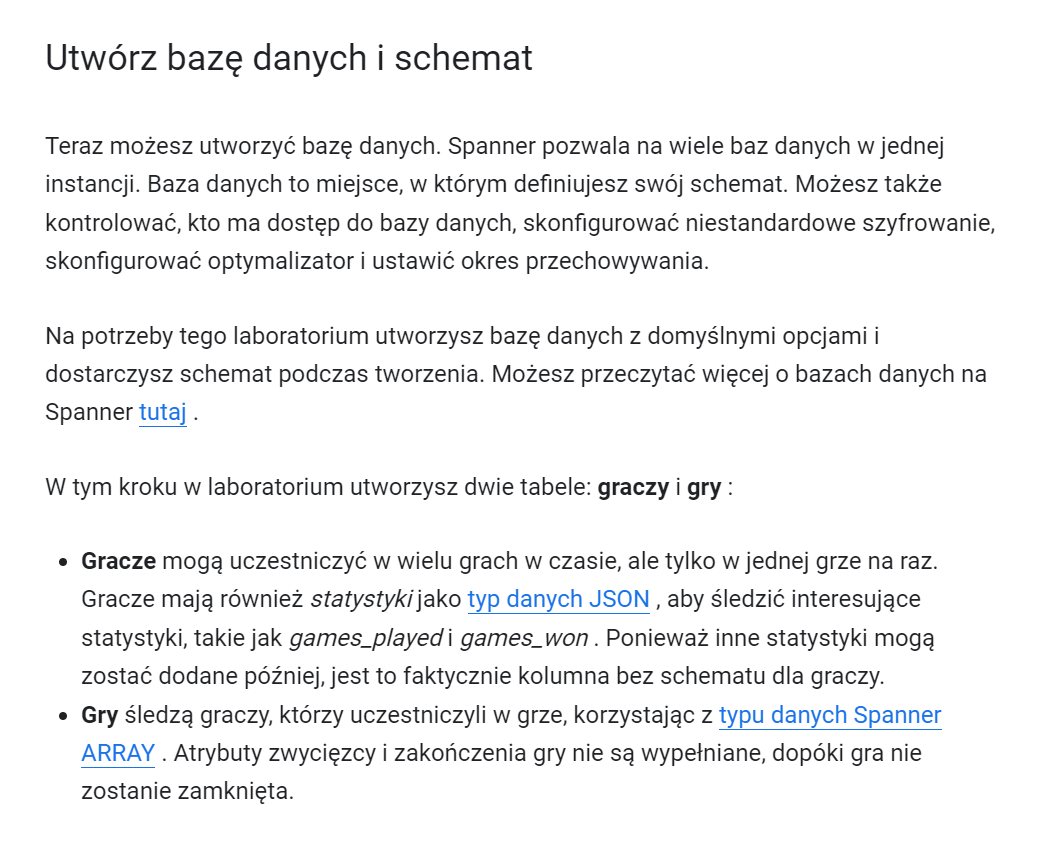

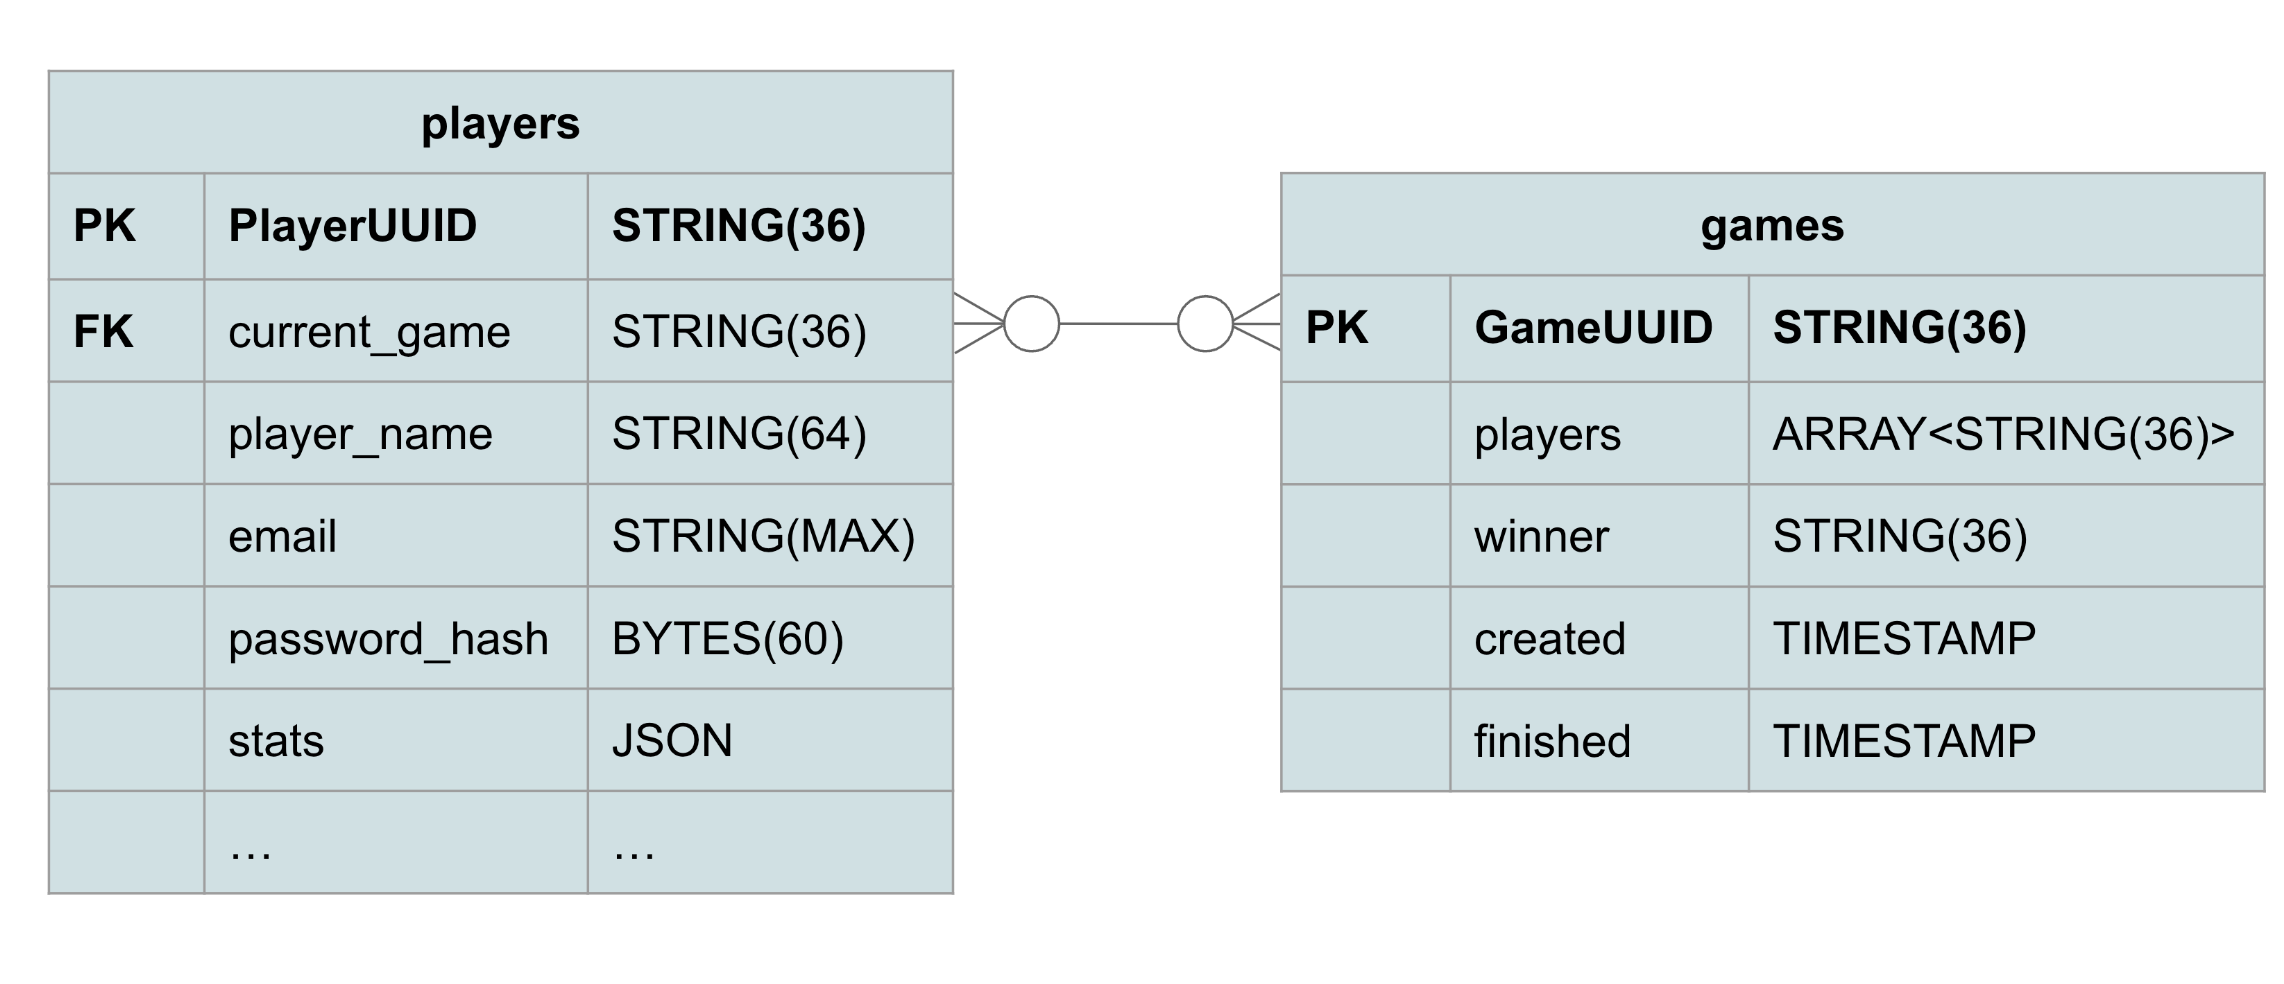

In [ ]:
# https://cloud.google.com/spanner/docs/databases

# https://cloud.google.com/spanner/docs/reference/standard-sql/data-types#json_type

# https://cloud.google.com/spanner/docs/reference/standard-sql/data-types#array_type

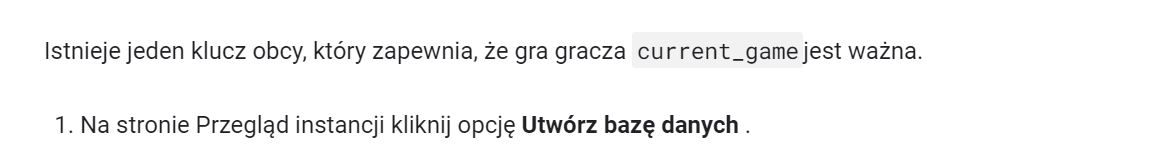

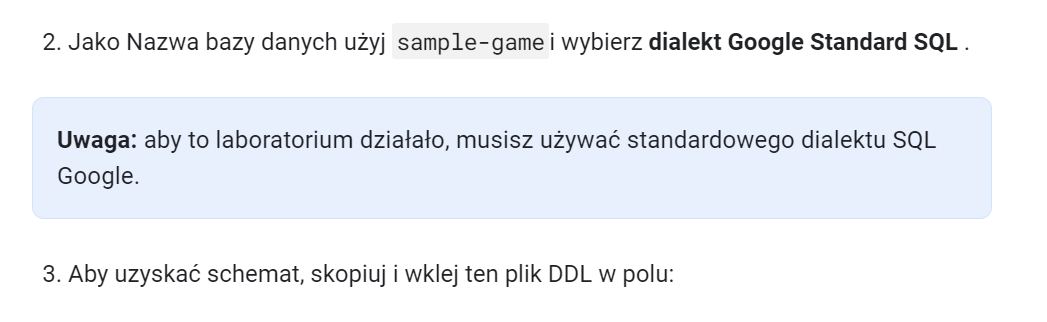

In [ ]:
# sample-game

In [ ]:
CREATE TABLE games (
  gameUUID STRING(36) NOT NULL,
  players ARRAY<STRING(36)> NOT NULL,
  winner STRING(36),
  created TIMESTAMP,
  finished TIMESTAMP,
) PRIMARY KEY(gameUUID);
CREATE TABLE players (
  playerUUID STRING(36) NOT NULL,
  player_name STRING(64) NOT NULL,
  email STRING(MAX) NOT NULL,
  password_hash BYTES(60) NOT NULL,
  created TIMESTAMP,
  updated TIMESTAMP,
  stats JSON,
  account_balance NUMERIC NOT NULL DEFAULT (0.00),
  is_logged_in BOOL,
  last_login TIMESTAMP,
  valid_email BOOL,
  current_game STRING(36),
  FOREIGN KEY (current_game) REFERENCES games (gameUUID),
) PRIMARY KEY(playerUUID);
CREATE UNIQUE INDEX PlayerAuthentication ON players(email) STORING (password_hash);
CREATE INDEX PlayerGame ON players(current_game);
CREATE UNIQUE INDEX PlayerName ON players(player_name);

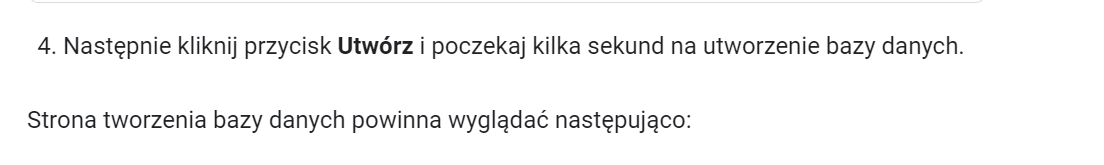

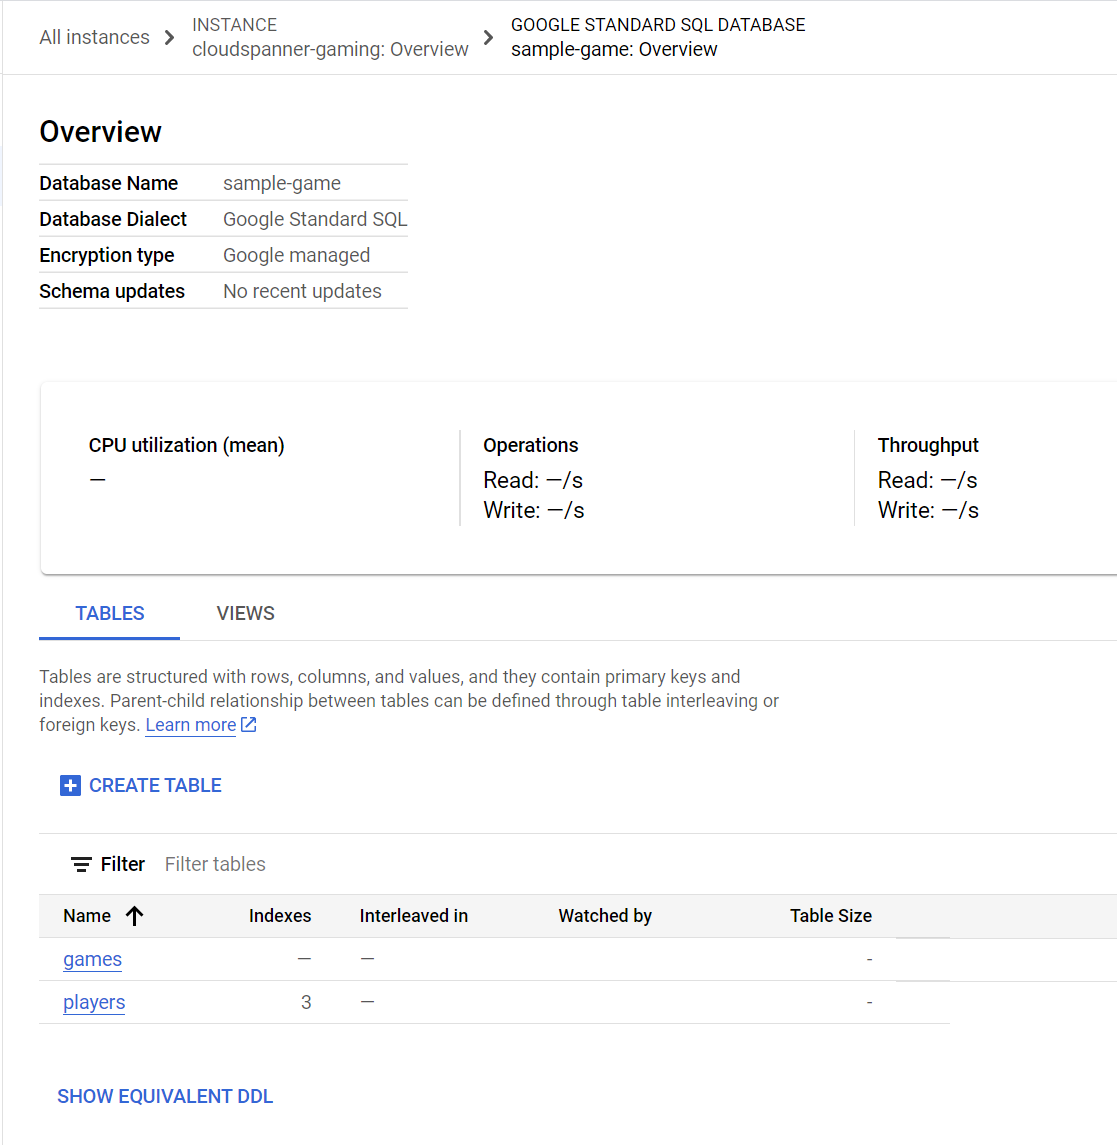

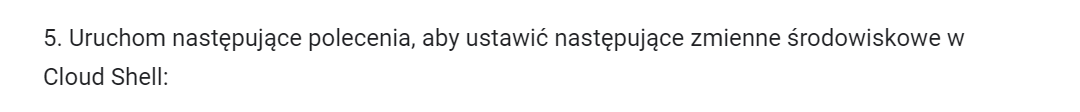

In [ ]:
export PROJECT_ID=$(gcloud config get-value project)
export SPANNER_PROJECT_ID=$PROJECT_ID
export SPANNER_INSTANCE_ID=cloudspanner-gaming
export SPANNER_DATABASE_ID=sample-game

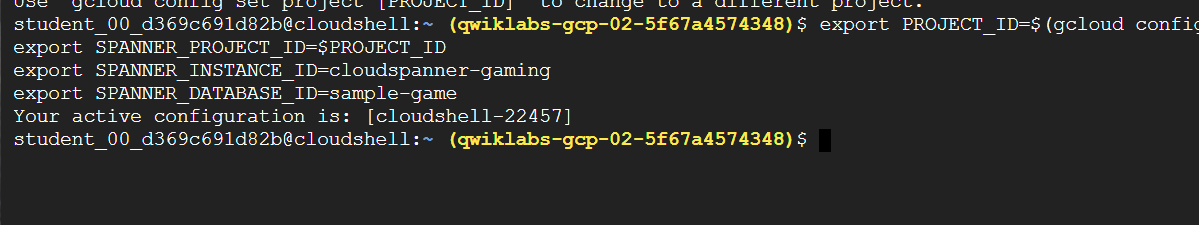

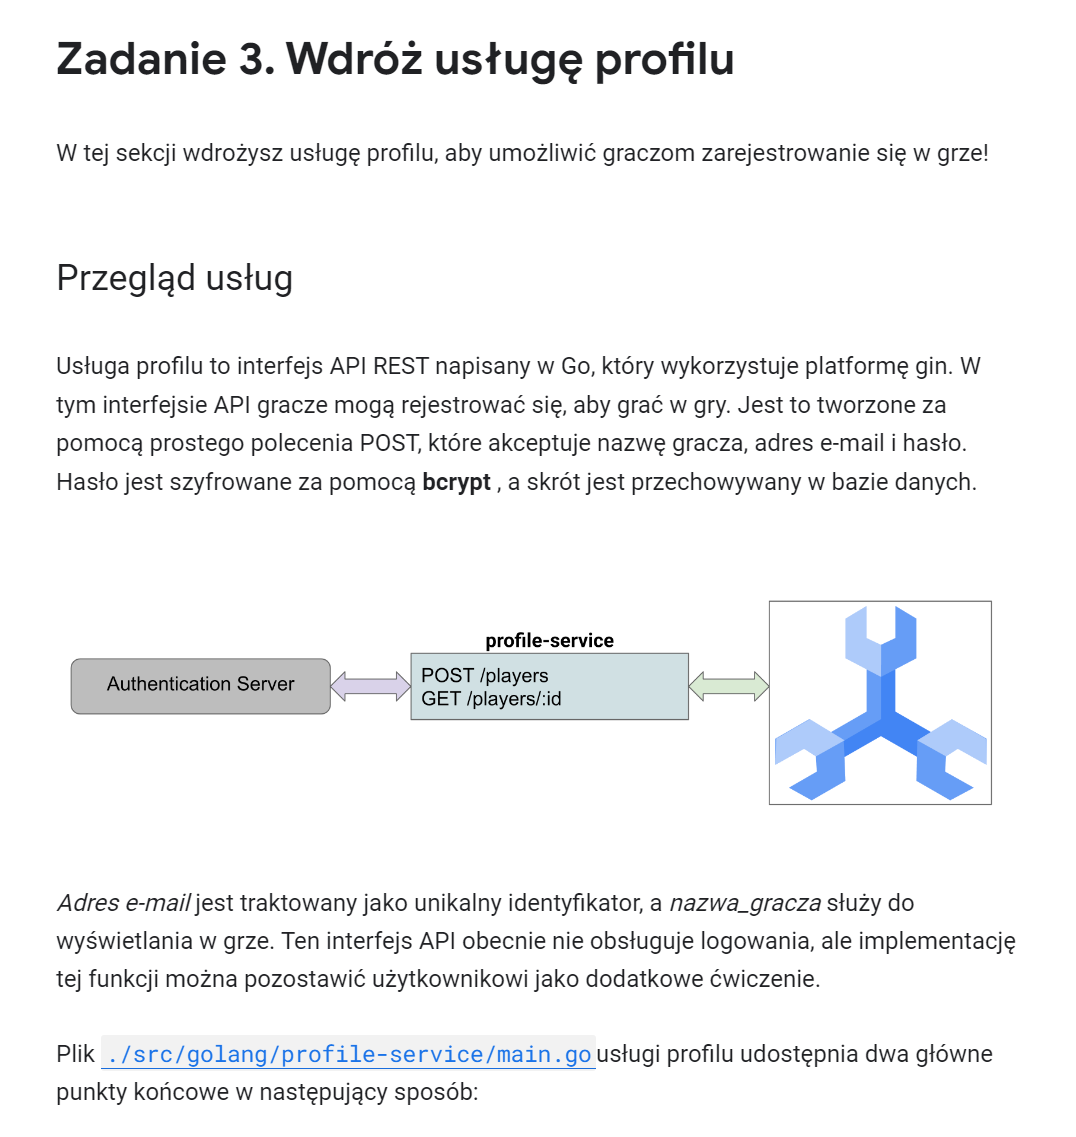

In [ ]:
func main() {
   configuration, _ := config.NewConfig()
   router := gin.Default()
   router.SetTrustedProxies(nil)
   router.Use(setSpannerConnection(configuration))
   router.POST("/players", createPlayer)
   router.POST("/players", createPlayer)
   router.GET("/players", getPlayerUUIDs)
   router.GET("/players/:id", getPlayerByID)
   router.Run(configuration.Server.URL())
}

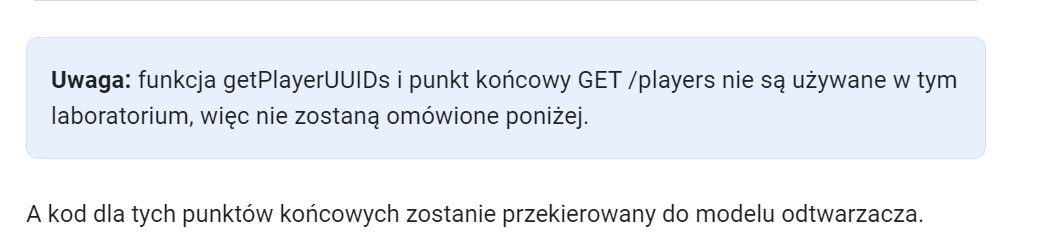

In [ ]:
func getPlayerByID(c *gin.Context) {
   var playerUUID = c.Param("id")
   ctx, client := getSpannerConnection(c)
   player, err := models.GetPlayerByUUID(ctx, client, playerUUID)
   if err != nil {
       c.IndentedJSON(http.StatusNotFound, gin.H{"message": "player not found"})
       return
   }
   c.IndentedJSON(http.StatusOK, player)
}
func createPlayer(c *gin.Context) {
   var player models.Player
   if err := c.BindJSON(&player); err != nil {
       c.AbortWithError(http.StatusBadRequest, err)
       return
   }
   ctx, client := getSpannerConnection(c)
   err := player.AddPlayer(ctx, client)
   if err != nil {
       c.AbortWithError(http.StatusBadRequest, err)
       return
   }
   c.IndentedJSON(http.StatusCreated, player.PlayerUUID)
}

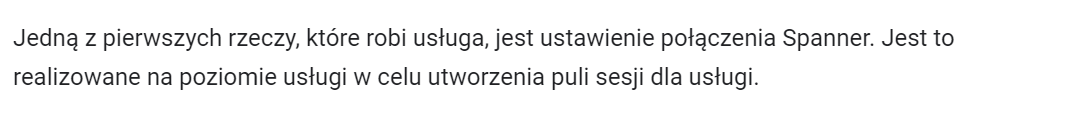

In [ ]:
func setSpannerConnection() gin.HandlerFunc {
   ctx := context.Background()
   client, err := spanner.NewClient(ctx, configuration.Spanner.URL())
   if err != nil {
       log.Fatal(err)
   }
   return func(c *gin.Context) {
       c.Set("spanner_client", *client)
       c.Set("spanner_context", ctx)
       c.Next()
   }
}

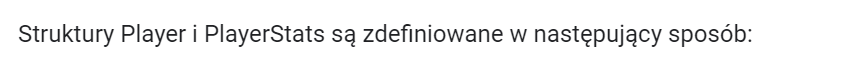

In [ ]:
type Player struct {
   PlayerUUID      string `json:"playerUUID" validate:"omitempty,uuid4"`
   Player_name     string `json:"player_name" validate:"required_with=Password Email"`
   Email           string `json:"email" validate:"required_with=Player_name Password,email"`
   // not stored in DB
   Password        string `json:"password" validate:"required_with=Player_name Email"`
   // stored in DB
   Password_hash   []byte `json:"password_hash"`
   created         time.Time
   updated         time.Time
   Stats           spanner.NullJSON `json:"stats"`
   Account_balance big.Rat          `json:"account_balance"`
   last_login      time.Time
   is_logged_in    bool
   valid_email     bool
   Current_game    string `json:"current_game" validate:"omitempty,uuid4"`
}
type PlayerStats struct {
   Games_played spanner.NullInt64 `json:"games_played"`
   Games_won    spanner.NullInt64 `json:"games_won"`
}

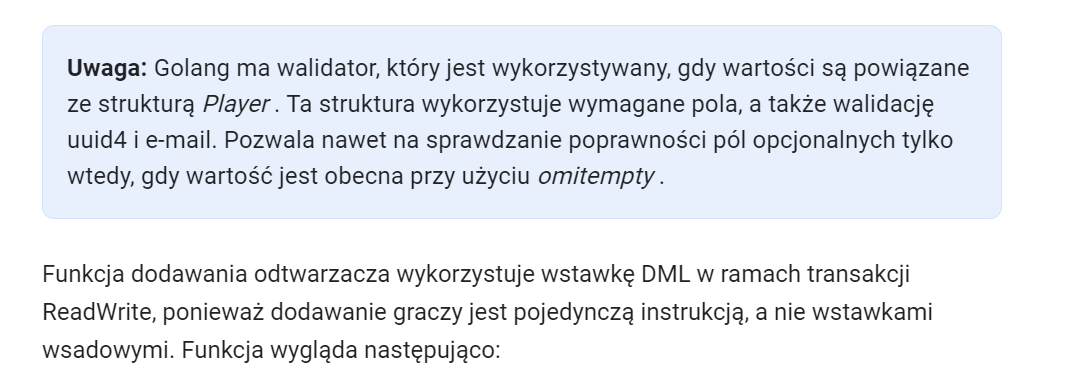

In [ ]:
func (p *Player) AddPlayer(ctx context.Context, client spanner.Client) error {
   // Validate based on struct validation rules
   err := p.Validate()
   if err != nil {
       return err
   }
   // take supplied password+salt, hash. Store in user_password
   passHash, err := hashPassword(p.Password)
   if err != nil {
       return errors.New("Unable to hash password")
   }
   p.Password_hash = passHash
   // Generate UUIDv4
   p.PlayerUUID = generateUUID()
   // Initialize player stats
   emptyStats := spanner.NullJSON{Value: PlayerStats{
       Games_played: spanner.NullInt64{Int64: 0, Valid: true},
       Games_won:    spanner.NullInt64{Int64: 0, Valid: true},
   }, Valid: true}
   // insert into spanner
   _, err = client.ReadWriteTransaction(ctx, func(ctx context.Context, txn *spanner.ReadWriteTransaction) error {
       stmt := spanner.Statement{
           SQL: `INSERT players (playerUUID, player_name, email, password_hash, created, stats) VALUES
                   (@playerUUID, @playerName, @email, @passwordHash, CURRENT_TIMESTAMP(), @pStats)
           `,
           Params: map[string]interface{}{
               "playerUUID":   p.PlayerUUID,
               "playerName":   p.Player_name,
               "email":        p.Email,
               "passwordHash": p.Password_hash,
               "pStats":       emptyStats,
           },
       }
       _, err := txn.Update(ctx, stmt)
       return err
   })
   if err != nil {
       return err
   }
   // return empty error on success
   return nil
}

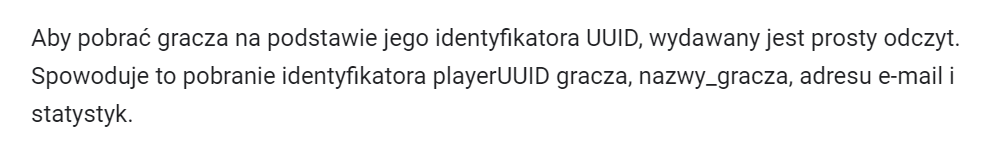

In [ ]:
func GetPlayerByUUID(ctx context.Context, client spanner.Client, uuid string) (Player, error) {
   row, err := client.Single().ReadRow(ctx, "players",
       spanner.Key{uuid}, []string{"playerUUID", "player_name", "email", "stats"})
   if err != nil {
       return Player{}, err
   }
   player := Player{}
   err = row.ToStruct(&player)
   if err != nil {
       return Player{}, err
   }
   return player, nil
}

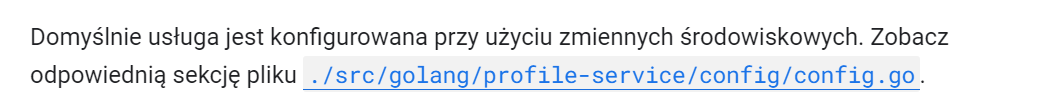

In [ ]:
func NewConfig() (Config, error) {
   *snip*
   // Server defaults
   viper.SetDefault("server.host", "localhost")
   viper.SetDefault("server.port", 8080)
   // Bind environment variable override
   viper.BindEnv("server.host", "SERVICE_HOST")
   viper.BindEnv("server.port", "SERVICE_PORT")
   viper.BindEnv("spanner.project_id", "SPANNER_PROJECT_ID")
   viper.BindEnv("spanner.instance_id", "SPANNER_INSTANCE_ID")
   viper.BindEnv("spanner.database_id", "SPANNER_DATABASE_ID")
   *snip*
   return c, nil
}

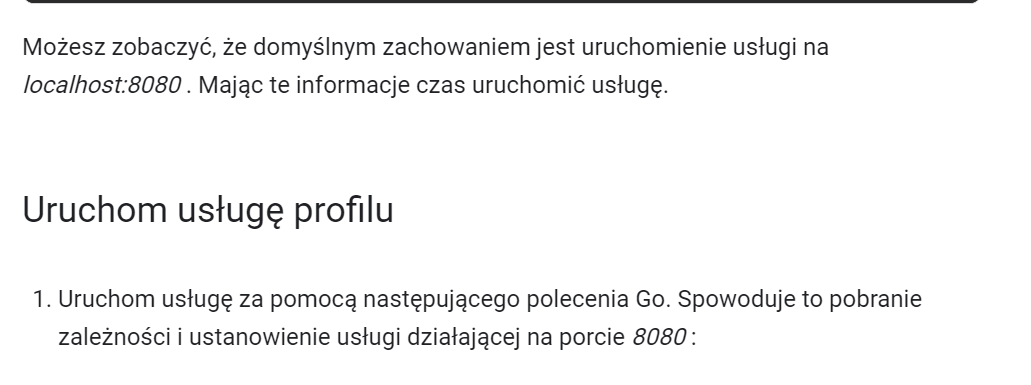

In [ ]:
cd ~/spanner-gaming-sample/src/golang/profile-service
go run . &

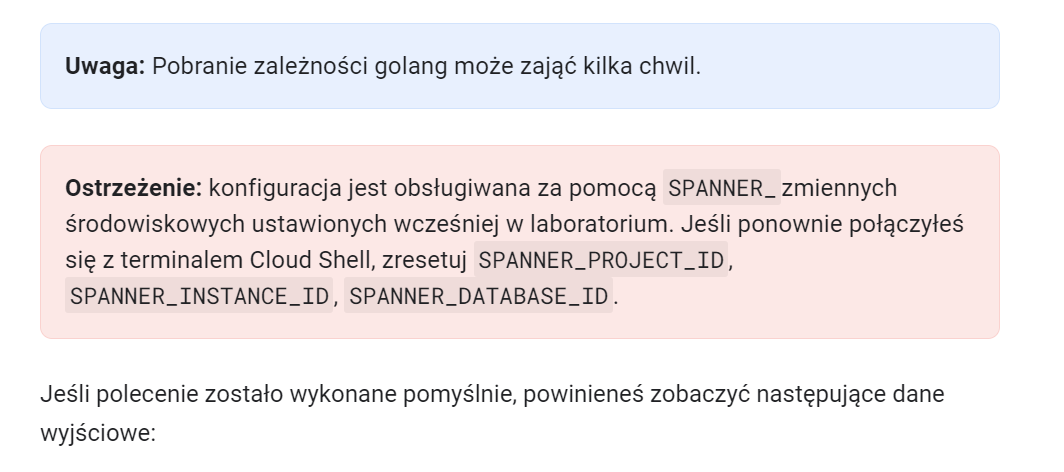

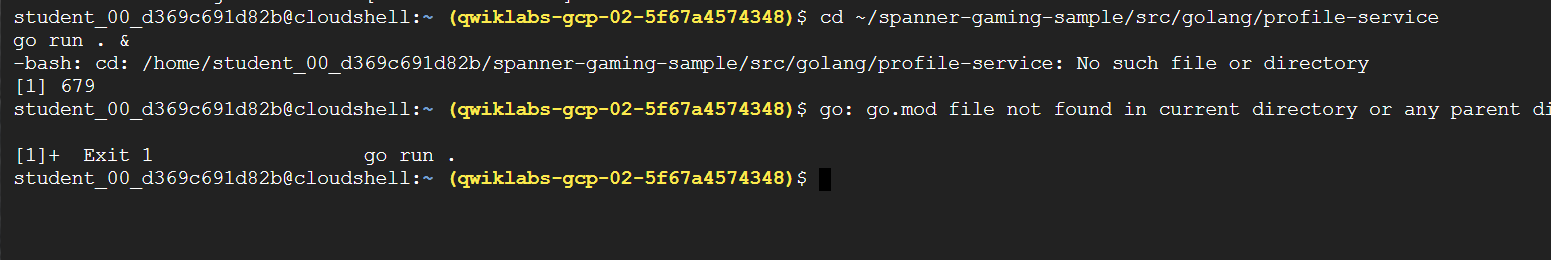

Error - niedkokończony Lab